In [1]:
# Import libraries
import cv2
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# Define the deep custom 3D CNN model
class DeepCrashNN(nn.Module):
    def __init__(self):
        super(DeepCrashNN, self).__init__()
        # Block 1: 3D Conv + BatchNorm + ReLU, spatial pooling only (temporal resolution remains)
        self.block1 = nn.Sequential(
            nn.Conv3d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Conv3d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2))  # Only spatial pooling: reduces H & W by 2
        )
        # Block 2: Increase channels to 32
        self.block2 = nn.Sequential(
            nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(1, 2, 2)),
            nn.Dropout3d(p=0.2)
        )
        # Block 3: Increase channels to 64 with global pooling at the end
        self.block3 = nn.Sequential(
            nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.Conv3d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d(1),  # Global average pooling over (T, H, W)
            nn.Dropout3d(p=0.2)
        )
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = self.block1(x)  # (B, 16, T, H/2, W/2)
        x = self.block2(x)  # (B, 32, T, H/4, W/4)
        x = self.block3(x)  # (B, 64, 1, 1, 1)
        x = x.view(x.size(0), -1)  # Flatten to (B, 64)
        x = self.dropout(x)
        x = self.fc(x)             # (B, 1)
        #return torch.sigmoid(x)    # Probability in [0,1]
        return x

# Instantiate the model and set it to evaluation mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = DeepCrashNN().to(device)
model.eval()
print("Deep custom 3D CNN model initialized and set to eval mode.")

Using device: cuda
Deep custom 3D CNN model initialized and set to eval mode.


In [3]:
# Load training and test CSV files
train_df = pd.read_csv('./nexar-collision-prediction/train.csv')
test_df = pd.read_csv('./nexar-collision-prediction/test.csv')

print("Training data loaded. Number of training videos:", len(train_df))
print("Test data loaded. Number of test videos:", len(test_df))

Training data loaded. Number of training videos: 1500
Test data loaded. Number of test videos: 1344


In [4]:
# Define function to extract randomly sampled frames from a video
def extract_random_frames(video_path, num_frames=40, resize=(224, 224)):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames <= 0:
        cap.release()
        return None

    # Randomly sample 'num_frames' unique indices and sort them to preserve temporal order
    frame_indices = sorted(np.random.choice(total_frames, num_frames, replace=False))

    frames = []
    current_frame = 0
    next_idx = 0
    ret = True
    while ret and next_idx < len(frame_indices):
        ret, frame = cap.read()
        if not ret:
            break
        if current_frame == frame_indices[next_idx]:
            frame = cv2.resize(frame, resize)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = frame.astype(np.float32) / 255.0  # Normalize to [0,1]
            frames.append(frame)
            next_idx += 1
        current_frame += 1
    cap.release()

    if len(frames) < num_frames:
        while len(frames) < num_frames:
            frames.append(frames[-1])

    # Convert frames to tensor with shape (B, C, T, H, W)
    frames = np.stack(frames, axis=0)           # (T, H, W, C)
    frames = np.transpose(frames, (3, 0, 1, 2))   # (C, T, H, W)
    frames_tensor = torch.from_numpy(frames).unsqueeze(0)  # Add batch dimension
    return frames_tensor

In [5]:
# Define prediction function
def predict_video(video_path):
    frames_tensor = extract_random_frames(video_path, num_frames=16, resize=(224,224))
    if frames_tensor is None:
        return 0.0  # Default probability if video cannot be processed
    frames_tensor = frames_tensor.to(device)
    with torch.no_grad():
        output = model(frames_tensor)  # Output shape: (B, 1)
        #prob = output.item()
        prob = torch.sigmoid(output).item()
    return prob

In [6]:
from torch.utils.data import Dataset, DataLoader

class VideoDataset(Dataset):
    def __init__(self, df, video_dir, num_frames=16, resize=(224, 224)):
        self.df = df
        self.video_dir = video_dir
        self.num_frames = num_frames
        self.resize = resize

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        video_id = int(float(row['id']))
        label = torch.tensor([row['target']], dtype=torch.float32)  # label 必須是 float
        video_filename = f"{video_id:05d}.mp4"
        video_path = os.path.join(self.video_dir, video_filename)

        frames = extract_random_frames(video_path, self.num_frames, self.resize)
        if frames is None:
            frames = torch.zeros((1, 3, self.num_frames, *self.resize))  # fallback

        return frames.squeeze(0), label


In [7]:
from sklearn.model_selection import train_test_split

train_split, val_split = train_test_split(train_df, test_size=0.2, random_state=42)

train_dataset = VideoDataset(train_split, video_dir='./nexar-collision-prediction/train')
val_dataset = VideoDataset(val_split, video_dir='./nexar-collision-prediction/train')

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)


In [8]:
# 損失函數 & 優化器
#criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()


In [9]:
# 方式一：Adam
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 方式二：SGD
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

# 方式三：RMSprop
#optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-4)


In [10]:
from tqdm import tqdm
import matplotlib.pyplot as plt

 10%|█         | 1/10 [1:00:34<9:05:11, 3634.66s/it]

Epoch [1/10] - Train Loss: 0.6939 | Val Loss: 0.6751
✅ 新最佳模型已儲存（Val Loss: 0.6751）


 20%|██        | 2/10 [2:00:08<7:59:50, 3598.85s/it]

Epoch [2/10] - Train Loss: 0.6804 | Val Loss: 0.6792


 30%|███       | 3/10 [3:01:29<7:04:15, 3636.54s/it]

Epoch [3/10] - Train Loss: 0.6853 | Val Loss: 0.6760


 40%|████      | 4/10 [4:02:23<6:04:20, 3643.44s/it]

Epoch [4/10] - Train Loss: 0.6681 | Val Loss: 0.6673
✅ 新最佳模型已儲存（Val Loss: 0.6673）


 50%|█████     | 5/10 [5:03:23<5:04:07, 3649.40s/it]

Epoch [5/10] - Train Loss: 0.6628 | Val Loss: 0.6795


 60%|██████    | 6/10 [6:04:16<4:03:21, 3650.43s/it]

Epoch [6/10] - Train Loss: 0.6587 | Val Loss: 0.6668
✅ 新最佳模型已儲存（Val Loss: 0.6668）


 70%|███████   | 7/10 [7:04:45<3:02:10, 3643.49s/it]

Epoch [7/10] - Train Loss: 0.6739 | Val Loss: 0.6821


 80%|████████  | 8/10 [8:05:46<2:01:38, 3649.19s/it]

Epoch [8/10] - Train Loss: 0.6587 | Val Loss: 0.6799


 90%|█████████ | 9/10 [9:06:43<1:00:51, 3651.47s/it]

Epoch [9/10] - Train Loss: 0.6418 | Val Loss: 0.6810


100%|██████████| 10/10 [10:09:16<00:00, 3655.65s/it]

Epoch [10/10] - Train Loss: 0.6536 | Val Loss: 0.6778


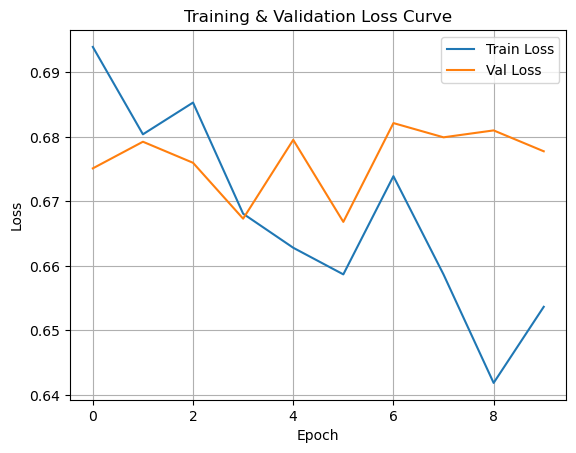

In [11]:
best_val_loss = float('inf')
num_epochs = 10

train_losses = []
val_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0

    for videos, labels in train_loader:
        videos = videos.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # ===== 驗證階段 =====
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for videos, labels in val_loader:
            videos = videos.to(device)
            labels = labels.to(device)
            outputs = model(videos)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    # 儲存每個 epoch 的 loss
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # ===== 儲存最佳模型 =====
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print(f"新最佳模型已儲存（Val Loss: {best_val_loss:.4f}）")

# ===== 畫圖 =====
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
'''
# Generate predictions for training videos
train_predictions = []

for idx, row in train_df.iterrows():
    # Convert video ID to integer and format with leading zeros (5 digits)
    video_id = int(float(row['id']))
    video_filename = f"{video_id:05d}.mp4"  # e.g., 01924.mp4
    video_path = os.path.join("D:/nexar-collision-prediction/train", video_filename)
    prob = predict_video(video_path)
    train_predictions.append(prob)
    if idx % 50 == 0:
        print(f"Processed {idx} training videos...")

train_df['predicted_score'] = train_predictions
print("Training predictions generated.")
'''

'\n# Generate predictions for training videos\ntrain_predictions = []\n\nfor idx, row in train_df.iterrows():\n    # Convert video ID to integer and format with leading zeros (5 digits)\n    video_id = int(float(row[\'id\']))\n    video_filename = f"{video_id:05d}.mp4"  # e.g., 01924.mp4\n    video_path = os.path.join("D:/nexar-collision-prediction/train", video_filename)\n    prob = predict_video(video_path)\n    train_predictions.append(prob)\n    if idx % 50 == 0:\n        print(f"Processed {idx} training videos...")\n\ntrain_df[\'predicted_score\'] = train_predictions\nprint("Training predictions generated.")\n'

In [13]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()


DeepCrashNN(
  (block1): Sequential(
    (0): Conv3d(3, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=

In [14]:
# Generate predictions for test videos
test_predictions = []

for idx, row in test_df.iterrows():
    video_id = int(float(row['id']))
    video_filename = f"{video_id:05d}.mp4"
    video_path = os.path.join("./nexar-collision-prediction/test", video_filename)
    prob = predict_video(video_path)
    test_predictions.append(prob)
    if idx % 50 == 0:
        print(f"Processed {idx} test videos...")

test_df['score'] = test_predictions
print("Test predictions generated.")

Processed 0 test videos...
Processed 50 test videos...
Processed 100 test videos...
Processed 150 test videos...
Processed 200 test videos...
Processed 250 test videos...
Processed 300 test videos...
Processed 350 test videos...
Processed 400 test videos...
Processed 450 test videos...
Processed 500 test videos...
Processed 550 test videos...
Processed 600 test videos...
Processed 650 test videos...
Processed 700 test videos...
Processed 750 test videos...
Processed 800 test videos...
Processed 850 test videos...
Processed 900 test videos...
Processed 950 test videos...
Processed 1000 test videos...
Processed 1050 test videos...
Processed 1100 test videos...
Processed 1150 test videos...
Processed 1200 test videos...
Processed 1250 test videos...
Processed 1300 test videos...
Test predictions generated.


In [15]:
# Save submission file
submission = test_df[['id', 'score']]
submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully.")

Submission file 'submission.csv' created successfully.
